In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

## Chargement des données

In [2]:
df = pd.read_csv("dataset-68eb8f248e099277381881.csv")


In [3]:
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


In [5]:
df.describe()

,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,1000.000000,970.000000,1000.000000
mean,500.500000,10.059970,16.982000,4.579381,56.732000
std,288.819436,5.696656,7.204553,2.914394,22.070915
min,1.000000,0.590000,5.000000,0.000000,8.000000
25%,250.750000,5.105000,11.000000,2.000000,41.000000
50%,500.500000,10.190000,17.000000,5.000000,55.500000
75%,750.250000,15.017500,23.000000,7.000000,71.000000
max,1000.000000,19.990000,29.000000,9.000000,153.000000


In [6]:
# df["Courier_Experience_yrs"].fillna(df["Courier_Experience_yrs"].mean(), inplace=True)
# for col in ["Weather", "Traffic_Level", "Time_of_Day"]:
#     df[col].fillna(df[col].mode()[0], inplace=True)
# Fill numeric column with mean
df["Courier_Experience_yrs"] = df["Courier_Experience_yrs"].fillna(df["Courier_Experience_yrs"].mean())

# Fill categorical columns with mode
for col in ["Weather", "Traffic_Level", "Time_of_Day"]:
    df[col] = df[col].fillna(df[col].mode()[0])


In [7]:
def check_columns_info(df):
    info = pd.DataFrame({
        "Type": df.dtypes,
        "Missing": df.isnull().sum()
    })
    return info
check_columns_info(df)

,Type,Missing
Order_ID,int64,0
Distance_km,float64,0
Weather,object,0
Traffic_Level,object,0
Time_of_Day,object,0
Vehicle_Type,object,0
Preparation_Time_min,int64,0
Courier_Experience_yrs,float64,0
Delivery_Time_min,int64,0


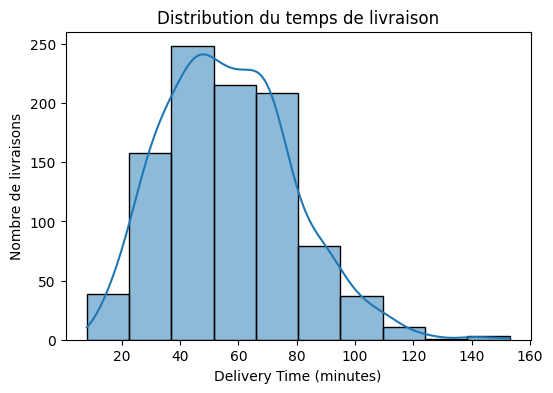

In [8]:
plt.figure(figsize=(6,4))
sns.histplot(df["Delivery_Time_min"], bins=10, kde=True)
plt.title("Distribution du temps de livraison")
plt.xlabel("Delivery Time (minutes)")
plt.ylabel("Nombre de livraisons")
plt.show()

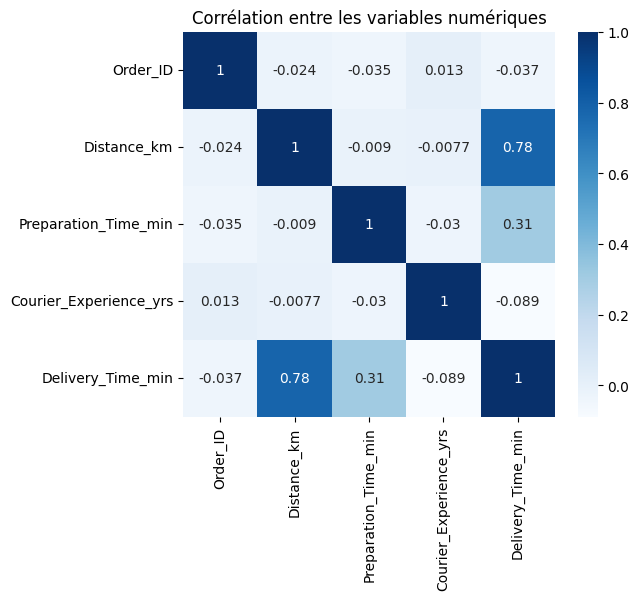

In [9]:
plt.figure(figsize=(6,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="Blues")
plt.title("Corrélation entre les variables numériques")
plt.show()

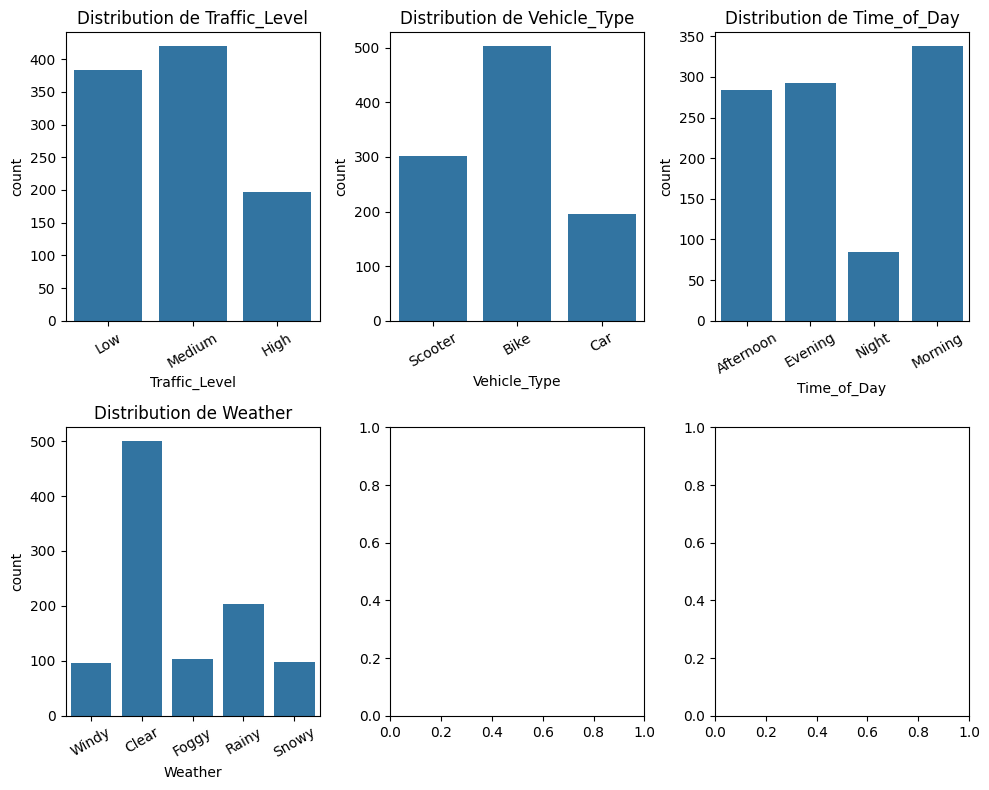

In [10]:
cat_vars = ["Traffic_Level", "Vehicle_Type", "Time_of_Day", "Weather"]

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = axes.flatten()

for i, col in enumerate(cat_vars):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f"Distribution de {col}")
    axes[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

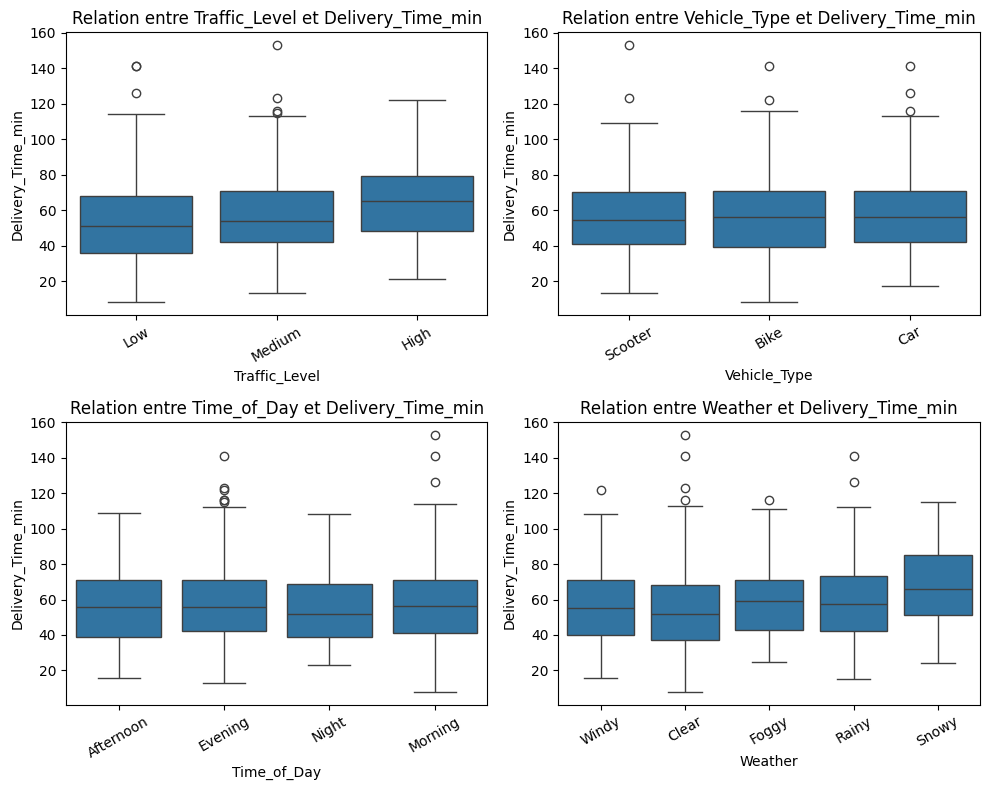

In [11]:
cat_vars = ["Traffic_Level", "Vehicle_Type", "Time_of_Day", "Weather"]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
for i, col in enumerate(cat_vars):
    sns.boxplot(data=df, x=col, y="Delivery_Time_min", ax=axes[i])
    axes[i].set_title(f"Relation entre {col} et Delivery_Time_min")
    axes[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd

# Encoder les colonnes catégorielles
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Séparer X et y
X = df_encoded.drop("Delivery_Time_min", axis=1)
y = df_encoded["Delivery_Time_min"]

# Modèle
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
regressor.fit(X, y)

# Scores
print(f"OOB Score: {regressor.oob_score_:.3f}")
print(f"R² Score: {regressor.score(X, y):.3f}")

# Validation croisée (K-Fold = 5)
cv_scores = cross_val_score(regressor, X, y, cv=5, scoring='r2')
print(f"Cross-validation R² moyen: {np.mean(cv_scores):.3f}")


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


OOB Score: 0.463
R² Score: 0.942
Cross-validation R² moyen: 0.675


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
